In [1]:
import pandas as pd
# import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class _Preprocessing():
    
    def __init__(self, data_name, data_type, time_window, forecasting_term, train_ratio = 0.7):  
        
        self.dt = pd.read_csv(data_name, usecols=[1]).iloc[:8000,:].clip(lower=0).astype('float32')
        self.data_type = data_type 
        self.time_window = time_window
        self.forecasting_term = forecasting_term
        self.train_ratio = train_ratio
        self.scaler = MinMaxScaler()
    
    def preprocessing(self):
        
        # Data Normalization
        self.scaler.fit_transform(self.dt)
                
        # Train Test Seperation
        len_train = int(len(self.dt)*self.train_ratio)
        
        train = self.dt.iloc[:len_train,:]
        test = self.dt.iloc[len_train:,:]
        
        trainX, testX, trainY, testY = [], [], [], []
        
        for i in range(self.time_window, len(train)-29):
            trainX.append(train.iloc[(i-self.time_window):i-self.time_window + 10,:].values)
            trainY.append(train.iloc[i-self.time_window + 10:i-self.time_window + 10+20,:].values)

        for i in range(self.time_window, len(test)-10-19):
            testX.append(test.iloc[(i-self.time_window):i-self.time_window+10,:].values)
            testY.append(test.iloc[i-self.time_window + 10:i-self.time_window + 10+20,:].values)


        trainX = np.array(trainX)
        trainY = np.array(trainY)

        trainY = trainY.reshape(trainY.shape[0] , trainY.shape[1])
        testX = np.array(testX)        
        testY = np.array(testY)        
        testY = testY.reshape(testY.shape[0] , testY.shape[1])
        
        # print(trainX[:10])
        # print(trainY[:10])
        return trainX, trainY, testX, testY, self.scaler

## CRU Cell

In [2]:
from statsmodels.tsa.seasonal import STL

import pandas as pd
import numpy as np
import tensorflow as tf

class _CRUCell(tf.keras.Model):
    
    def __init__(self, in_dim, hid_dim, bias=True):
        super(_CRUCell, self).__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.bias = bias
        
        self.wx_t = tf.keras.layers.Dense(hid_dim*3, activation=None, use_bias=True)
        self.wx_s = tf.keras.layers.Dense(hid_dim*3, activation=None, use_bias=True)
        self.wx_r = tf.keras.layers.Dense(hid_dim, activation=None, use_bias=True)
        
        self.wh_t = tf.keras.layers.Dense(hid_dim*3, activation=None, use_bias=True)
        self.wh_s = tf.keras.layers.Dense(hid_dim*3, activation=None, use_bias=True)
        self.wh_r = tf.keras.layers.Dense(hid_dim, activation=None, use_bias=True)
        
        self.reset_parameters()
            

    def __call__(self, x, hid_state = None):
        
        lamda = 0.5
        x_t, x_s, x_r = self.ts_decompose(x)
        
        if hid_state is None:
            hid_state = np.zeros((3, x.size(1), self.hid_dim))
        
        with tf.GradientTape() as tape:
            
            x_t = self.wx_t(x_t)
            x_s = self.wx_s(x_s)
            x_r = self.wx_r(x_r)
            # print(x_t.shape)
            h_t = self.wh_t(hid_state[0,:,:])
            h_s = self.wh_s(hid_state[1,:,:])
            # print(h_t.shape)
        
        x_autocor_t, x_cor_t, x_new_t = np.split(x_t, 3, axis=1)
        x_autocor_s, x_cor_s, x_new_s = np.split(x_s, 3, axis=1)
        h_autocor_t, h_cor_t, h_new_t = np.split(h_t, 3, axis=1)
        h_autocor_s, h_cor_s, h_new_s = np.split(h_s, 3, axis=1)

        autocor_t = tf.nn.sigmoid(x_autocor_t + h_autocor_t)
        autocor_s = tf.nn.sigmoid(x_autocor_s + h_autocor_s)
        
        cor_t = tf.nn.sigmoid(x_cor_t + h_cor_s)
        cor_s = tf.nn.sigmoid(x_cor_s + h_cor_t)
        
        new_t = lamda*np.tanh(x_new_t + (autocor_t * h_new_t)) + (1-lamda)*np.tanh(x_new_t + (cor_t * h_new_s))
        new_s = lamda*np.tanh(x_new_s + (autocor_s * h_new_s)) + (1-lamda)*np.tanh(x_new_s + (cor_s * h_new_t))
        
       
        with tf.GradientTape() as tape:

            hid_state[0,:,:] = new_t
            hid_state[1,:,:] = new_s
            hid_state[2,:,:] = np.tanh(x_r)
        
        return hid_state

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hid_dim)
        
        for w in self.get_parameters():
            w.data.uniform_(-std, std)
    def get_parameters(self):
        # Return the trainable parameters of the model
        return self.trainable_variables
        
    def ts_decompose(self, x):
        
        x = pd.DataFrame(x)
        
        dates = pd.date_range('1990-01-01', periods = len(x), freq='D')
        x.index = dates
        trend = []
        seasonal = []
        resid = []
        for i in range(len(x.columns)):
            stl = STL(x[i])
            res = stl.fit()
            trend.append(res.trend.values)
            seasonal.append(res.seasonal.values)
            resid.append(res.resid.values)

        trend = np.array(trend)
        seasonal = np.array(seasonal)
        resid = np.array(resid)

        
        trend = np.transpose(np.array(trend))
        seasonal = np.transpose(np.array(seasonal))
        resid = np.transpose(np.array(resid))
        
        return trend, seasonal, resid

## CRU

In [3]:
import tensorflow as tf
import numpy as np

class _CRU(tf.keras.Model):
    
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, bias = True):
        super(_CRU, self).__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.bias = bias
        self.out_dim = out_dim
        
        self.cell_list =  []
        self.cell_list.append(_CRUCell(self.in_dim,
                                               self.hid_dim, 
                                               self.bias))
        for l in range(1, self.num_layers): ## will not be executed 
            self.cell_list.append(_CRUCell(self.hid_dim,
                                                   self.hid_dim,
                                                   self.bias))

        self.fc = tf.keras.models.Sequential([
            tf.keras.layers.Dense(out_dim, input_shape=(hid_dim,)),
            tf.keras.layers.ELU()
            ])
            
    def get_parameters(self):
        # Return the trainable parameters of the model
        return self.trainable_variables
    
    def __call__(self, input, hid_state=None):
        # print("today is saurav kapadiya's ",type(input))
        if hid_state is None:
            hid_state = np.zeros((self.num_layers, 3, input.shape[0], self.hid_dim))
        else:
            hid_state = hid_state

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(hid_state[layer,:, :, :])
        
        for t in range(input.shape[1]):

            for layer in range(self.num_layers):

                if layer == 0:
                    hid_layer = self.cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hid_layer = self.cell_list[layer](hidden[layer - 1],hidden[layer])
                
                hidden[layer] = hid_layer
                
            outs.append(hid_layer)
       
        feature = np.mean(outs[-1],axis=1)
    
        out = np.sum(outs[-1],axis=0)
        out = np.array(out)

        out = self.fc(out)
        
        return out, feature

## Training the model

In [4]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [5]:
from sklearn.metrics import mean_squared_error as mse

import numpy as np
import tensorflow as tf 

class ModelTrain():
    
    def __init__(self, data_name, data_type, time_window, forecasting_term):

        self.in_dim = time_window
        pre = _Preprocessing(data_name, data_type, time_window, forecasting_term)
        self.trainX, self.trainY, self.testX, self.testY, self.scaler = pre.preprocessing()
        # print(type(self.trainX))
        
                    
    def _fit(self, hid_dim, out_dim, num_layers, epoch):
        
        model = _CRU(self.in_dim, hid_dim, out_dim, num_layers)
        # Instantiate an optimizer.
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
        # Instantiate a loss function.
        mse = tf.keras.losses.MeanSquaredError()
        
        for e in range(epoch):
            # print("start of epoch #",e)
    
            with tf.GradientTape() as tape:
                trainPredict, _ = model(self.trainX)
                loss = mse(self.trainY, trainPredict)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss , model.trainable_weights,unconnected_gradients=tf.UnconnectedGradients.ZERO)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
            if (e+1) % 100 == 0:
                with tf.GradientTape() as tape:
                    testPred,_ = model(self.testX)
                    testPred =   np.array(testPred)
                    trainPredict = np.array(trainPredict)
                    # print(self.trainY[15:20])
                    testdata = self.testY
                    traindata = self.trainY

                    
                    trainPredict = self.scaler.inverse_transform(trainPredict)
                    testPred = self.scaler.inverse_transform(testPred)
                    testdata = self.scaler.inverse_transform(testdata)
                    traindata = self.scaler.inverse_transform(traindata)

                    test_mape = np.mean(abs((np.array(testPred)-np.array(testdata))/np.array(testPred)))*100
                    test_rmse = rmse(testPred, testdata)
                    train_rmse = rmse(trainPredict, traindata)
                print('[Epoch: {}/{}] [Train RMSE: {}] [Test RMSE: {}] [Test MAPE: {}]'.format(
                    e+1, epoch, str(train_rmse)[:6], str(test_rmse)[:6], str(test_mape)[:6]))
                # print(trainY.shape)
        
        return model,traindata,trainPredict,testdata,testPred

In [6]:
import matplotlib.pyplot as plt

data_name = 'output2.csv'
data_type = 'univariate'

time_window = 1
forecasting_term = 1
    
model = ModelTrain(data_name, data_type, time_window, forecasting_term)

In [7]:
hid_dim = 512
out_dim = 20
num_layers = 1
epoch = 1000

m,trainY,trainPredict,testY,testPred = model._fit(hid_dim, out_dim, num_layers, epoch)


[Epoch: 100/1000] [Train RMSE: 26197.] [Test RMSE: 32589.] [Test MAPE: 3132.6]
[Epoch: 200/1000] [Train RMSE: 23585.] [Test RMSE: 29228.] [Test MAPE: 5733.4]
[Epoch: 300/1000] [Train RMSE: 21328.] [Test RMSE: 26307.] [Test MAPE: 864.50]
[Epoch: 400/1000] [Train RMSE: 19386.] [Test RMSE: 23779.] [Test MAPE: 645.77]
[Epoch: 500/1000] [Train RMSE: 17725.] [Test RMSE: 21601.] [Test MAPE: 482.32]
[Epoch: 600/1000] [Train RMSE: 16313.] [Test RMSE: 19733.] [Test MAPE: 458.76]
[Epoch: 700/1000] [Train RMSE: 15120.] [Test RMSE: 18140.] [Test MAPE: 1078.0]
[Epoch: 800/1000] [Train RMSE: 14120.] [Test RMSE: 16790.] [Test MAPE: 709.32]
[Epoch: 900/1000] [Train RMSE: 13287.] [Test RMSE: 15654.] [Test MAPE: 421.82]
[Epoch: 1000/1000] [Train RMSE: 12600.] [Test RMSE: 14705.] [Test MAPE: 546.22]


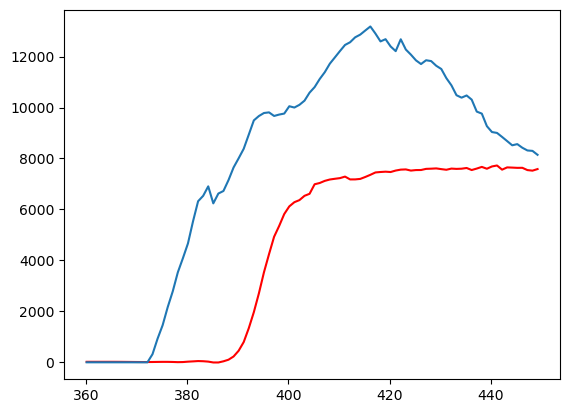

In [11]:
Best_Predict_Test=testPred
Best_Predict_Train=trainPredict

x_data=np.linspace(0,testY.shape[0], num=testY.shape[0])
# x_data.shape
plt.plot(x_data[360:450], trainPredict[360:450,19], label='actual',color='r')
plt.plot(x_data[360:450], trainY[360:450,19], label='predicted')
# plt.show()